## Stress Tests VaR

#### Introduction

**Objectif du projet :**  
Calcul et backtesting de la VaR et de l’Expected Shortfall sur un portefeuille multi-actifs via approches historique, paramétrique et Monte Carlo, avec stress tests et analyse des exceptions.

**Paramètres et définitions clés :**

- **VaR (Value at Risk)** :  
  Estimation de la perte maximale probable sur un horizon donné et pour un niveau de confiance donné. Elle répond à la question : *« Quelle est la perte maximale que je risque de subir avec X% de probabilité ? »*. 
  
  La formule est :
$
\text{VaR}_{\alpha}(X) = \inf \{ x \in \mathbb{R} : P(X \le x) \ge \alpha \}
$
où $X$ représente les pertes du portefeuille.


- **Expected Shortfall (ES)** :  
  Moyenne des pertes lorsque celles-ci dépassent la VaR. Cette mesure prend en compte la gravité des pertes extrêmes, contrairement à la VaR qui ne donne qu’un seuil.

- **Approches de calcul** :
   1. **Historique** : utilise les rendements passés pour estimer la distribution des pertes futures.  
   2. **Paramétrique (Variance-Covariance)** : suppose une distribution théorique des rendements (souvent normale) pour calculer la VaR.  
   3. **Monte Carlo** : génère des scénarios aléatoires basés sur un modèle de marché pour estimer la VaR et l’ES.

- **Stress Tests** :  
  Analyse de l’impact sur le portefeuille de scénarios extrêmes.

- **Backtesting** :  
  Analyse des exceptions, vérification du nombre de jours où la perte réelle dépasse la VaR calculée. Permet d’évaluer la fiabilité du modèle.

#### Simulation des données

Actifs du portefeuille :

- 3 actions, 2 obligations

Horizon : 5 an par simulation

Rendements annuels moyens :

- Actions : 7% à 10%

- Obligations : 2% à 4%

Volatilité annuelle :

- Actions : 15% à 25%

- Obligations : 3% à 6%

Corrélations : actions positives, obligations moins corrélées

In [39]:
import numpy as np
import pandas as pd

np.random.seed(999)

# Paramètres annuels
mu_annual = np.array([0.08, 0.07, 0.10, 0.03, 0.025]) # Actions puis obligations
sigma_annual = np.array([0.2, 0.18, 0.25, 0.04, 0.05])
corr_matrix = np.array([
    [1.0, 0.6, 0.5, 0.1, 0.0],
    [0.6, 1.0, 0.55, 0.1, 0.05],
    [0.5, 0.55, 1.0, 0.0, 0.05],
    [0.1, 0.1, 0.0, 1.0, 0.2],
    [0.0, 0.05, 0.05, 0.2, 1.0]
])

# Conversion en journalière
mu_daily = mu_annual / 252
sigma_daily = sigma_annual / np.sqrt(252)
cov_daily = np.outer(sigma_daily, sigma_daily) * corr_matrix

On simule les rendements avec une loi de student : 

- La t permet de modéliser des pertes extrêmes plus réalistes avec des queues épaisses.

- Les actions ont des degrés de liberté faibles (4 ou 5), ce qui produit des queues épaisses, donc plus de chances de gros mouvements extrêmes.

- Les obligations ont des degrés de liberté plus élevés (10), ce qui se rapproche d’une distribution normale.

    Pour simuler des rendements avec une variance souhaitée $\sigma^2$ :

    $
    X = \mu + \sigma \cdot \frac{T_\nu}{\sqrt{\nu / (\nu - 2)}}
    $

où :  

- $T_\nu$: variable aléatoire t standard avec $\nu$ degrés de liberté  
- Le facteur $\sqrt{\nu / (\nu - 2)}$ standardise la variance à 1  

Ainsi, $X$ aura une moyenne $\mu$ et une variance $\sigma^2$.

In [40]:
# Simuler rendements journaliers avec loi t pour actions
n_assets = 5
n_days = 252*5
df_t = np.array([4,4,5,10,10]) # Dégrés de libertés

returns = np.zeros((n_days, n_assets))
for i in range(n_assets):
    returns[:,i] = mu_daily[i] + sigma_daily[i] * np.random.standard_t(df=df_t[i], size=n_days) / np.sqrt(df_t[i]/(df_t[i]-2))

dates = pd.date_range(start="2021-01-01", periods=n_days, freq='B')
df_returns_daily = pd.DataFrame(returns, index=dates, columns=['Action_1','Action_2','Action_3','Obligation_1','Obligation_2'])

Création du portefeuille 60% actions, 40% obligations (20% dans chaque actif).

In [41]:
# Poids du portefeuille
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# Rendements journaliers du portefeuille
portfolio_returns_daily = df_returns_daily.dot(weights)

#### Value At Risk

VaR historique

In [42]:
alpha = 0.01  # niveau de confiance 99%
VaR_hist_99 = -np.percentile(portfolio_returns_daily, 100*alpha)
print(f"VaR historique 99% : {VaR_hist_99:.4f}")

VaR historique 99% : 0.0106


VaR normale multivariée

$
\text{VaR}_\alpha = - \left( \mathbf{w}^\top \boldsymbol{\mu} + z_\alpha \, \sqrt{\mathbf{w}^\top \Sigma \mathbf{w}} \right)
$

$
\mathbf{w} : \text{vecteur des poids du portefeuille} \\
\boldsymbol{\mu} : \text{vecteur des rendements moyens des actifs} \\
\Sigma : \text{matrice de covariance des rendements des actifs} \\
z_\alpha : \text{quantile de la loi normale pour le niveau de confiance } \alpha
$

In [43]:
from scipy.stats import norm

# Moyennes journalières des actifs
mean_vector = df_returns_daily.mean().values  # vecteur 5x1

# Matrice de covariance journalière
cov_matrix = df_returns_daily.cov().values  # matrice 5x5

# Rendement moyen du portefeuille
port_mean = np.dot(weights, mean_vector)

# Volatilité du portefeuille (multi-actifs)
port_std = np.sqrt(weights.T @ cov_matrix @ weights)

# VaR paramétrique multivariée
VaR_param_99 = -(port_mean + port_std * norm.ppf(alpha))

print(f"VaR normale multivariée 99% : {VaR_param_99:.4f}")

VaR normale multivariée 99% : 0.0103


VaR Monte Carlo

La méthode de Monte Carlo repose sur la génération de scénarios aléatoires 
de rendements possibles pour un portefeuille.

1. **Génération des scénarios simulés du portefeuille :**  
   On génère $N$ rendements simulés directement pour le portefeuille selon une loi Student-t :
   $
   R_p^{(i)} \sim t_\nu(\mu_p, \sigma_p), \quad i = 1, \dots, N
   $
   où $\mu_p$ et $\sigma_p$ sont la moyenne et l'écart-type estimés du portefeuille, 
   et $\nu$ est le nombre de degrés de liberté.
   Les paramètres sont trouvés par maximum de vraissemblance.

2. **Estimation de la VaR :**  
   On estime la distribution empirique des rendements simulés et on retient le quantile au niveau $\alpha$ :
   $
   \text{VaR}_\alpha = - \, \text{Quantile}_\alpha \left( R_p^{(i)} \right)
   $


In [44]:
from scipy.stats import t

# Rendements journaliers du portefeuille
R_p = portfolio_returns_daily.values

# Ajustement de la loi Student-t
df, loc, scale = t.fit(R_p)

print(f"Paramètres estimés : df = {df:.2f}, mu = {loc:.5f}, sigma = {scale:.5f}")

n_simulations = 100000  # nombre de tirages Monte Carlo

# Tirages Monte Carlo de la Student-t ajustée
simulated_portfolio_returns = t.rvs(df, loc=loc, scale=scale, size=n_simulations)

# Calcul de la VaR Monte Carlo 99%
VaR_mc_t_99 = -np.percentile(simulated_portfolio_returns, 100*alpha)
print(f"VaR Monte Carlo Student-t 99% : {VaR_mc_t_99:.4f}")

Paramètres estimés : df = 7.55, mu = 0.00043, sigma = 0.00396
VaR Monte Carlo Student-t 99% : 0.0112


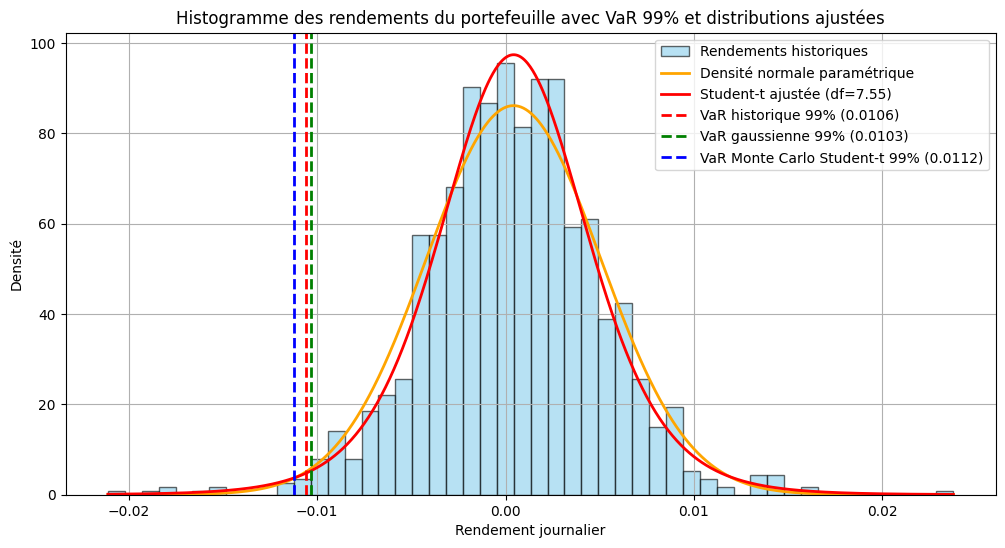

In [45]:
import matplotlib.pyplot as plt

# Histogramme des rendements historiques du portefeuille
plt.figure(figsize=(12,6))
plt.hist(portfolio_returns_daily, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Rendements historiques')

# Densité normale paramétrique
x = np.linspace(min(portfolio_returns_daily), max(portfolio_returns_daily), 1000)
plt.plot(x, norm.pdf(x, port_mean, port_std), color='orange', linewidth=2, label='Densité normale paramétrique')

# Densité Student-t ajustée sur le portefeuille
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), color='red', linewidth=2, label=f'Student-t ajustée (df={df:.2f})')

# Lignes des VaR
plt.axvline(-VaR_hist_99, color='red', linestyle='--', linewidth=2, label=f'VaR historique 99% ({VaR_hist_99:.4f})')
plt.axvline(-VaR_param_99, color='green', linestyle='--', linewidth=2, label=f'VaR gaussienne 99% ({VaR_param_99:.4f})')
plt.axvline(-VaR_mc_t_99, color='blue', linestyle='--', linewidth=2, label=f'VaR Monte Carlo Student-t 99% ({VaR_mc_t_99:.4f})')

# Labels, légende et grille
plt.title("Histogramme des rendements du portefeuille avec VaR 99% et distributions ajustées")
plt.xlabel("Rendement journalier")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.show()

#### Stress Testing

Scénario : Le marché des actions chute d'environ 10% en une journée. 

In [51]:
# Rendements hypothétiques pour le scénario
scenario_returns = np.array([-0.12, -0.08, -0.10, 0.02, 0.01])

# Calcul du rendement du portefeuille
portfolio_return_scenario = np.dot(weights, scenario_returns)

# Conversion en perte et en pourcentage
portfolio_loss_percent = -portfolio_return_scenario * 100

print(f"Perte journalière du portefeuille sous scénario hypothétique : {portfolio_loss_percent:.2f}%")

Perte journalière du portefeuille sous scénario hypothétique : 5.40%


#### Backtesting & exceptions

Les dépassement de la VaR doivent être indépendants et la proportion de dépassements doit tendre vers le seuil $\alpha$.

In [55]:
# Exemple : backtesting pour VaR Monte Carlo Student-t
R_p = portfolio_returns_daily.values

# Identifier les jours où la perte dépasse la VaR
exceptions = R_p < -VaR_hist_99  # True si dépassement
n_exceptions = exceptions.sum()
total_days = len(R_p)
exception_rate = n_exceptions / total_days

print(f"Nombre d'exceptions : {n_exceptions} sur {total_days} jours")
print(f"Taux d'exceptions observé : {exception_rate:.4f} (attendu : 0.01)")

Nombre d'exceptions : 13 sur 1260 jours
Taux d'exceptions observé : 0.0103 (attendu : 0.01)


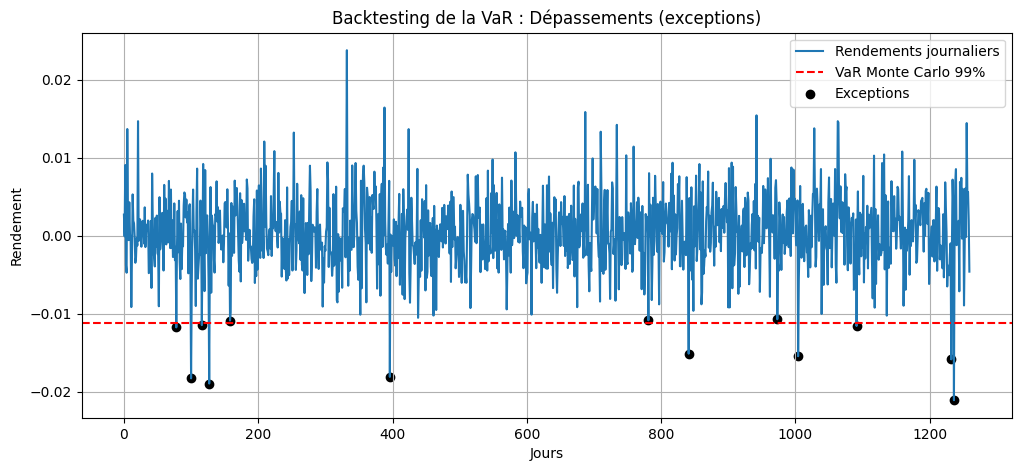

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(R_p, label='Rendements journaliers')
plt.axhline(-VaR_mc_t_99, color='red', linestyle='--', label='VaR Monte Carlo 99%')
plt.scatter(np.where(exceptions)[0], R_p[exceptions], color='black', label='Exceptions')
plt.xlabel('Jours')
plt.ylabel('Rendement')
plt.title('Backtesting de la VaR : Dépassements (exceptions)')
plt.legend()
plt.grid(True)
plt.show()

Exemple de tests: 
- Kupiec POF
- Christoffersen (Indépendance + Proportion Of Failure)